In [1]:
#!pip install linearmodels

In [1]:
from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from sklearn.metrics import mean_absolute_error as MAE
from scipy.stats import boxcox
from scipy.special import inv_boxcox
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# Explaining Happiness

## Differences to the Original Report
In the [original report](https://worldhappiness.report/ed/2022/) pooled OLS regression have been used to explain the happiness using others at hand. Here this will be repeated with some changes. The list of differences to the report is as follows:
- Imputation has been done with much less information here. In the original report, missing data has been imputed carefully using other useful data. For example, for perception of corruption, control of corruption from [WGI](https://info.worldbank.org/governance/wgi/Home/) has been been utilized. However, in our case the imputation was done without such tedious process, but with the help of simple machine learning algorithms.
- The GDP (per capita in terms of Purchasing Power Parity (PPP) adjusted to constant 2017 international dollars) data of year 2021 was not available to the report, so it was extrapolated in the original report. In this analysis, we have them available from World Bank, the missings ones were imputed just like the others.

Except above there is no data row either added or removed from the data, for a fair comparison between the studies. 

Let us now start by reading the data!

In [2]:
wh = pd.read_csv("data/full_wh22.csv", index_col=0)
wh.describe()

year  Life Ladder  Log GDP per capita  Social support  \
count  2089.000000  2089.000000         2089.000000     2089.000000   
mean   2013.727621     5.473747            9.379408        0.811830   
std       4.455614     1.115567            1.142248        0.118745   
min    2005.000000     2.178809            5.526723        0.290184   
25%    2010.000000     4.651972            8.475151        0.748287   
50%    2014.000000     5.405246            9.474574        0.835509   
75%    2017.000000     6.294282           10.345659        0.904694   
max    2021.000000     8.018934           11.665803        0.987343   

       Healthy life expectancy at birth  Freedom to make life choices  \
count                       2089.000000                   2089.000000   
mean                          63.232180                      0.745417   
std                            6.894532                      0.139767   
min                            6.720000                      0.257534   
25%                           59.150002                      0.654125   
50%                           64.959999                      0.766716   
75%                           68.400002                      0.856025   
max                           74.349998                      0.985178   

        Generosity  Perceptions of corruption  Positive affect  \
count  2089.000000                2089.000000      2089.000000   
mean      0.000229                   0.744287         0.651331   
std       0.158459                   0.182461         0.105448   
min      -0.335739                   0.035198         0.178886   
25%      -0.108066                   0.682109         0.570538   
50%      -0.021534                   0.794301         0.662436   
75%       0.088441                   0.867257         0.736459   
max       0.706377                   1.000000         0.883586   

       Negative affect  Confidence in national government      inflation  
count      2089.000000                        2089.000000    2089.000000  
mean          0.270514                           0.485211      75.493927  
std           0.085550                           0.186598    2853.924252  
min           0.082737                           0.068769     -72.730000  
25%           0.208130                           0.343268       1.557907  
50%           0.260324                           0.472183       3.416268  
75%           0.321357                           0.609015       6.920336  
max           0.704590                           1.000000  130060.200000

In [3]:
def pooled_ols(in_data, panel_indices, y_name):
    '''Runs the Pooled OLS on the input data
    Arguments:
        pols_data (pandas.DataFrame): Dataframe to run the pooled ols on.
        panel_indexes (list of strings): Ordered list of strings to set as the index of the pols_data, 
            which is a panel data. So the first index should be entity, and the second one time.
        y_name (str): Name of the response variable, which should exist as a column name in pols_data.
    
    Returns:
        result (linearmodels.panel.Results.PanelResults): Fit results of the pooled ols
    '''
    pols_data = in_data.copy()
    pols_data.set_index(panel_indices, inplace=True)
    x = sm.add_constant(pols_data.drop(columns=[y_name]))
    model = PanelOLS(pols_data[y_name], x, time_effects=True)
    result = model.fit()
    display(result)
    pred = result.predict(x)
    
    return result, MAE(pols_data[y_name], pred)

# Analysis Repetition
## Only with Original Variables
Using the same variables and Pooled OLS the analysis is repeated below. In the report, the confidence in national government is not shown in the variables, so it is also excluded here. Here is a comparison:

- The adjusted R² here is 0.7668 (p-value=.0000) here, where the original report has it as 0.7777. In the end the report explains the variance of the data around 1% better than this analysis. However, the imputation time spent there would require way more person hours. Compared to the time spent for the imputation in this analysis, I believe 1% loss sounds not bad, since most of the variance could still be explained.
- Coefficient of Perceptions of corruption is -0.5637 here compared to -0.704, which is one of the biggest coeffienct difference. As the data had many data missing in this column, I suppose this is the source of not only for the change in the coefficient, but also the overall result.
- The negative affect also has also a similar delta, but the parameter is already insignificant in both anaysis.

In [4]:
result_orig, mae_orig = pooled_ols(
    in_data=wh.drop(columns=["inflation", "Confidence in national government"]).copy()
    , panel_indices=["Country name", "year"]
    , y_name="Life Ladder"
)

PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:            Life Ladder   R-squared:                        0.7678
Estimator:                   PanelOLS   R-squared (Between):              0.8360
No. Observations:                2089   R-squared (Within):               0.2363
Date:                Fri, Apr 07 2023   R-squared (Overall):              0.7668
Time:                        10:53:58   Log-likelihood                   -1647.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      852.93
Entities:                         166   P-value                           0.0000
Avg Obs:                       12.584   Distribution:                  F(8,2064)
Min Obs:                       1.0000                                           
Max Obs:                       16.000   F-statistic (robust):             852.93
                                        P-value                           0.0000
Time periods:                      17   Distribution:                  F(8,2064)
Avg Obs:                       122.88                                           
Min Obs:                       27.000                                           
Max Obs:                       147.00                                           
                                                                                
                                        Parameter Estimates                                         
====================================================================================================
                                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------------------------
const                               -2.8848     0.1771    -16.287     0.0000     -3.2321     -2.5374
Log GDP per capita                   0.3967     0.0202     19.646     0.0000      0.3571      0.4363
Social support                       1.8397     0.1587     11.594     0.0000      1.5285      2.1509
Healthy life expectancy at birth     0.0268     0.0030     8.8271     0.0000      0.0209      0.0328
Freedom to make life choices         0.4882     0.1240     3.9385     0.0001      0.2451      0.7313
Generosity                           0.3928     0.0828     4.7440     0.0000      0.2304      0.5551
Perceptions of corruption           -0.5637     0.0791    -7.1268     0.0000     -0.7189     -0.4086
Positive affect                      2.2854     0.1471     15.535     0.0000      1.9969      2.5739
Negative affect                      0.0573     0.1649     0.3479     0.7280     -0.2659      0.3806
====================================================================================================

F-test for Poolability: 2.9540
P-value: 0.0001
Distribution: F(16,2064)

Included effects: Time
PanelEffectsResults, id: 0x7f68ddc53c10

## Analysis with Confidence in National Government Added
In the report, the confidence in national government data has not been used, as seen on the Table 2.1 for Pooled OLS. Here this column has been imputed and given as an independent variable to the same model. Below are the results:
- It helps explain the variable in the response variable slightly better with the R² of 0.7727. This brings us almost to the same R² performance of the World Health Report, which is 0.7777.
- What especially surprising is that the confidence in national government has a negative coefficient, even a very large one, -0.7. It is really puzzling because the variable has a very positive connotation. On the other hand, many values of this column are imputated. Hence drawing more conclusions from this could be deceptive.

In [5]:
result_with_confid, mae_with_config = pooled_ols(
    in_data=wh.drop(columns=["inflation"])
    , panel_indices=["Country name", "year"]
    , y_name="Life Ladder"
)

display(pd.DataFrame([result_orig.params, result_with_confid.params], index=["Original", "With ConfInNatGovernment"]))

PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:            Life Ladder   R-squared:                        0.7745
Estimator:                   PanelOLS   R-squared (Between):              0.8499
No. Observations:                2089   R-squared (Within):               0.2013
Date:                Fri, Apr 07 2023   R-squared (Overall):              0.7727
Time:                        10:53:58   Log-likelihood                   -1616.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      787.08
Entities:                         166   P-value                           0.0000
Avg Obs:                       12.584   Distribution:                  F(9,2063)
Min Obs:                       1.0000                                           
Max Obs:                       16.000   F-statistic (robust):             787.08
                                        P-value                           0.0000
Time periods:                      17   Distribution:                  F(9,2063)
Avg Obs:                       122.88                                           
Min Obs:                       27.000                                           
Max Obs:                       147.00                                           
                                                                                
                                         Parameter Estimates                                         
=====================================================================================================
                                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------------------------
const                                -1.8984     0.2154    -8.8152     0.0000     -2.3207     -1.4761
Log GDP per capita                    0.3662     0.0203     18.050     0.0000      0.3264      0.4059
Social support                        1.6547     0.1582     10.460     0.0000      1.3445      1.9649
Healthy life expectancy at birth      0.0240     0.0030     7.9704     0.0000      0.0181      0.0299
Freedom to make life choices          0.9532     0.1359     7.0152     0.0000      0.6868      1.2197
Generosity                            0.4430     0.0819     5.4117     0.0000      0.2825      0.6036
Perceptions of corruption            -0.8733     0.0874    -9.9878     0.0000     -1.0448     -0.7018
Positive affect                       2.1030     0.1469     14.319     0.0000      1.8150      2.3911
Negative affect                      -0.0512     0.1631    -0.3138     0.7537     -0.3710      0.2687
Confidence in national government    -0.7041     0.0900    -7.8236     0.0000     -0.8806     -0.5276
=====================================================================================================

F-test for Poolability: 3.3470
P-value: 0.0000
Distribution: F(16,2063)

Included effects: Time
PanelEffectsResults, id: 0x7f68d9b7ee50

const  Log GDP per capita  Social support  \
Original                 -2.884769            0.396736        1.839727   
With ConfInNatGovernment -1.898385            0.366152        1.654682   

                          Healthy life expectancy at birth  \
Original                                          0.026811   
With ConfInNatGovernment                          0.024031   

                          Freedom to make life choices  Generosity  \
Original                                      0.488227    0.392769   
With ConfInNatGovernment                      0.953232    0.443013   

                          Perceptions of corruption  Positive affect  \
Original                                  -0.563730         2.285394   
With ConfInNatGovernment                  -0.873287         2.103048   

                          Negative affect  Confidence in national government  
Original                         0.057344                                NaN  
With ConfInNatGovernment        -0.051170                          -0.704073

## Analysis with All Variables
Now it is time to add the inflation to the variables. Here the same preprocessing of the inflation will be applied as in the EDA notebook, since there are big spikes in some countries, which lowers the importance of the overall inflation.
- Neither the coefficients nor the result changes too much. 
- Inflation is significant with a coefficient of -0.0056. This does not look large but each 1% inflation would correspond to a happiness score of decreased -0.0056.

In [6]:
wh.loc[wh.inflation>27,"inflation"] = 27
wh.loc[wh.inflation<-10,"inflation"] = -10
result_with_all, mae_with_all = pooled_ols(
    in_data=wh
    , panel_indices=["Country name", "year"]
    , y_name="Life Ladder"
)
display(pd.DataFrame([result_orig.params, result_with_confid.params, result_with_all.params], index=["Original", "With ConfInNatGovernment", "All In"]))

PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:            Life Ladder   R-squared:                        0.7752
Estimator:                   PanelOLS   R-squared (Between):              0.8514
No. Observations:                2089   R-squared (Within):               0.2012
Date:                Fri, Apr 07 2023   R-squared (Overall):              0.7727
Time:                        10:53:58   Log-likelihood                   -1613.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      710.88
Entities:                         166   P-value                           0.0000
Avg Obs:                       12.584   Distribution:                 F(10,2062)
Min Obs:                       1.0000                                           
Max Obs:                       16.000   F-statistic (robust):             710.88
                                        P-value                           0.0000
Time periods:                      17   Distribution:                 F(10,2062)
Avg Obs:                       122.88                                           
Min Obs:                       27.000                                           
Max Obs:                       147.00                                           
                                                                                
                                         Parameter Estimates                                         
=====================================================================================================
                                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------------------------
const                                -1.7901     0.2193    -8.1640     0.0000     -2.2201     -1.3601
Log GDP per capita                    0.3568     0.0206     17.325     0.0000      0.3164      0.3972
Social support                        1.7015     0.1591     10.697     0.0000      1.3896      2.0135
Healthy life expectancy at birth      0.0240     0.0030     7.9644     0.0000      0.0181      0.0299
Freedom to make life choices          0.9227     0.1362     6.7732     0.0000      0.6556      1.1899
Generosity                            0.4455     0.0818     5.4490     0.0000      0.2852      0.6059
Perceptions of corruption            -0.8692     0.0873    -9.9520     0.0000     -1.0404     -0.6979
Positive affect                       2.0722     0.1472     14.080     0.0000      1.7836      2.3609
Negative affect                      -0.0352     0.1630    -0.2162     0.8288     -0.3549      0.2844
Confidence in national government    -0.6851     0.0902    -7.5968     0.0000     -0.8620     -0.5083
inflation                            -0.0056     0.0022    -2.5357     0.0113     -0.0100     -0.0013
=====================================================================================================

F-test for Poolability: 3.6330
P-value: 0.0000
Distribution: F(16,2062)

Included effects: Time
PanelEffectsResults, id: 0x7f68d9ba0a90

const  Log GDP per capita  Social support  \
Original                 -2.884769            0.396736        1.839727   
With ConfInNatGovernment -1.898385            0.366152        1.654682   
All In                   -1.790117            0.356783        1.701541   

                          Healthy life expectancy at birth  \
Original                                          0.026811   
With ConfInNatGovernment                          0.024031   
All In                                            0.023982   

                          Freedom to make life choices  Generosity  \
Original                                      0.488227    0.392769   
With ConfInNatGovernment                      0.953232    0.443013   
All In                                        0.922746    0.445518   

                          Perceptions of corruption  Positive affect  \
Original                                  -0.563730         2.285394   
With ConfInNatGovernment                  -0.873287         2.103048   
All In                                    -0.869165         2.072246   

                          Negative affect  Confidence in national government  \
Original                         0.057344                                NaN   
With ConfInNatGovernment        -0.051170                          -0.704073   
All In                          -0.035244                          -0.685122   

                          inflation  
Original                        NaN  
With ConfInNatGovernment        NaN  
All In                    -0.005611

## Results
R² has already been used as a comparison metric, now let us check/compare models from different perspectives. 

### An Additional Comparison: MAE

To get a better idea of the models, Mean Absolute Error (MAE) comparison could be used in addition to R². Since R² is about explaining the variance of the response variable with the variables, it inherintly compares the performance against a constant model. Let us see what MAE shows, which is actually about the errors made by the model. 

In the end, both metrics actually agree with each other, so we can rather confidently choose the second model. As MAE is the mean absolute error, its unit is the same as Life Ladder column.

In [19]:
results = pd.DataFrame(
    [
        [
            result.rsquared_overall for 
            result in [result_orig, result_with_confid, result_with_all]
        ],
        [mae_orig, mae_with_config, mae_with_all]
    ]
    , columns=["Original Data", "With ConfInNatGovernment", "All In"]
    , index=["R2","MAE"]
).T
results

R2       MAE
Original Data             0.766751  0.413698
With ConfInNatGovernment  0.772683  0.409463
All In                    0.772699  0.410440

### Residual Check
In the model we used the variables as they are, except for the handling of the outliers in inflation. To understand any possible anomaly let us check the residual plots. From this point on we will continue with only the second model, original data + confidence in national government. Here are the thoughts:

- Healthy life expectancy at birth has outliers and this could cost us performance. To prevent this, all the values under 35 will be assigned as 35.
- Predictions vs Residual graph has quadratical look. We can consider the simple two options: data cannot capture the nature of the dependent variable or it can. To understand this residual plots of input data would be useful.
- GDP, social support, and perception of corruption data have also a nonlinear characteristic, just like the one in predictions. To check whether we would get a better result or not, let us expand the data with the squares of these columns + all combinations of their multiplications.
- Optimization of the model based on preprocessing the data will be stopped here, because it would be unfair to use the all data to check strategies. For this, a proper train-validation-test data split should be followed first.

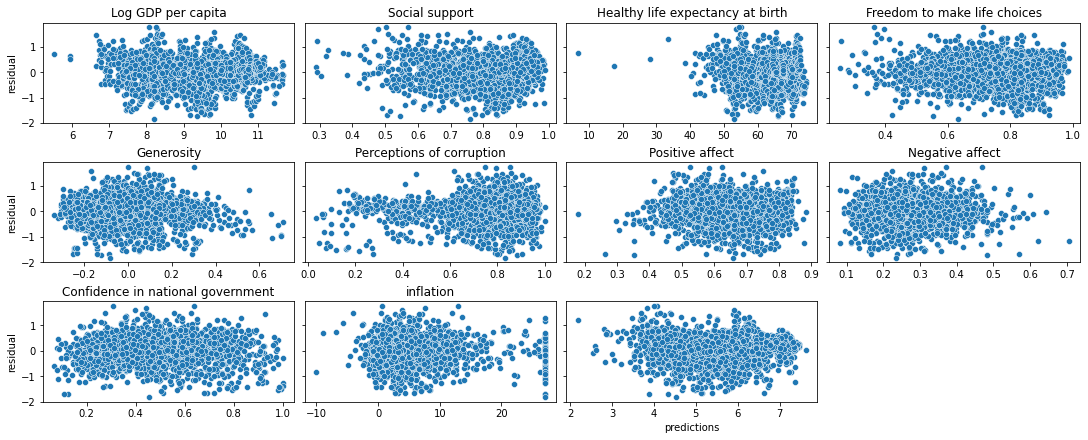

In [8]:
fig, axs = plt.subplots(3, 4, figsize=(15, 6), constrained_layout=True, sharex=False, sharey=True)
resids = result_with_confid.resids.reset_index()["residual"]
x = sm.add_constant(wh.drop(columns=["inflation","Life Ladder"]).set_index(["Country name","year"]))
preds = result_with_confid.predict(x).reset_index()
for ax, col in zip(axs.flat, wh.drop(columns=["Country name", "year", "Life Ladder"]).columns):
    sctrplt = sns.scatterplot(
        x=wh[col],
        y=resids,
        ax=ax
    )
    ax.set_title(col)
    ax.set_xlabel("")
    #sctrplt.set_xticklabels(sctrplt.get_xticklabels(),rotation=90)

sctrplt = sns.scatterplot(
    x=preds["predictions"],
    y=resids,
    ax=axs[2,2]
)
ax.set_title(col)
ax.set_xlabel("")

fig.delaxes(axs[2,3])

Assign 35 to the the values under 35, in order to decrease the effect of the outliers. Hopefully this would help increasing the columns contributions to the model!

In [9]:
wh.loc[wh["Healthy life expectancy at birth"]<35,"Healthy life expectancy at birth"] = 35

## Expanded Data: Square + Interactions
Let us now expand the data by using the square function on the 3 columns, determined in the previous step and by creating new columns to reflect interactions of those columns.

In [10]:
wh_expanded = wh.copy()
wh_expanded = wh_expanded.join(
    (
        wh_expanded[
            ["Log GDP per capita", "Social support", "Perceptions of corruption"]
        ]**2
    ).add_prefix("sq_")
)
wh_expanded["SocSupxCorr"] = wh_expanded["Social support"] * wh_expanded["Perceptions of corruption"]
wh_expanded["GDPxCorr"] = wh_expanded["Log GDP per capita"] * wh_expanded["Perceptions of corruption"]
wh_expanded["GDPxSocSup"] = wh_expanded["Log GDP per capita"] * wh_expanded["Social support"]
wh_expanded["GDPxCorrxSocSup"] = wh_expanded["Log GDP per capita"] \
    * wh_expanded["Perceptions of corruption"] \
    * wh_expanded["Social support"]

Notes on the result:

- As seen below, the R² has increased a good amount, from 0.7726 to 0.7904, which also surpasses the original report, whose R² is 0.777.
- Together with the improvement in the explanation of the variance, actual predictions have also got better, as MAE is 0.3952, previously it was 0.4094.
- Except the GDP, all the square terms are significant.

In [11]:
result_expanded, mae_expanded = pooled_ols(
    in_data=wh_expanded
    , panel_indices=["Country name", "year"]
    , y_name="Life Ladder"
)
print(mae_expanded)

PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:            Life Ladder   R-squared:                        0.7927
Estimator:                   PanelOLS   R-squared (Between):              0.8709
No. Observations:                2089   R-squared (Within):               0.2139
Date:                Fri, Apr 07 2023   R-squared (Overall):              0.7904
Time:                        10:53:59   Log-likelihood                   -1528.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      462.21
Entities:                         166   P-value                           0.0000
Avg Obs:                       12.584   Distribution:                 F(17,2055)
Min Obs:                       1.0000                                           
Max Obs:                       16.000   F-statistic (robust):             462.21
                                        P-value                           0.0000
Time periods:                      17   Distribution:                 F(17,2055)
Avg Obs:                       122.88                                           
Min Obs:                       27.000                                           
Max Obs:                       147.00                                           
                                                                                
                                         Parameter Estimates                                         
=====================================================================================================
                                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------------------------
const                                 11.393     3.3174     3.4344     0.0006      4.8874      17.899
Log GDP per capita                   -1.6068     0.4014    -4.0028     0.0001     -2.3940     -0.8196
Social support                       -15.659     4.4858    -3.4907     0.0005     -24.456     -6.8615
Healthy life expectancy at birth      0.0314     0.0032     9.8789     0.0000      0.0251      0.0376
Freedom to make life choices          0.7967     0.1322     6.0282     0.0000      0.5375      1.0559
Generosity                            0.2599     0.0810     3.2096     0.0013      0.1011      0.4186
Perceptions of corruption            -8.9051     4.2052    -2.1177     0.0343     -17.152     -0.6583
Positive affect                       1.9778     0.1434     13.791     0.0000      1.6965      2.2590
Negative affect                      -0.1002     0.1593    -0.6293     0.5292     -0.4126      0.2121
Confidence in national government    -0.5416     0.0887    -6.1061     0.0000     -0.7156     -0.3677
inflation                            -0.0052     0.0022    -2.3856     0.0171     -0.0094     -0.0009
sq_Log GDP per capita                 0.0236     0.0124     1.9057     0.0568     -0.0007      0.0479
sq_Social support                     2.8679     0.9801     2.9261     0.0035      0.9458      4.7900
sq_Perceptions of corruption         -1.9798     0.3076    -6.4369     0.0000     -2.5830     -1.3766
SocSupxCorr                           13.366     5.5771     2.3966     0.0166      2.4289      24.304
GDPxCorr                              1.5763     0.4916     3.2067     0.0014      0.6123      2.5403
GDPxSocSup                            1.7971     0.4736     3.7945     0.0002      0.8683      2.7259
GDPxCorrxSocSup                      -1.8990     0.6052    -3.1379     0.0017     -3.0859     -0.7122
=====================================================================================================

F-test for Poolability: 3.5735
P-value: 0.0000
Distribution: F(16,2055)

Included effects: Time
PanelEffectsResults, id: 0x7f68d8632be0

0.39522046426925406


### Results
To have a general overview on the results, here is a table to compare.

In [21]:
results = pd.concat(
    [
        results, 
        pd.DataFrame(
            [[result_expanded.rsquared_overall, mae_expanded]],
            columns=results.columns,
            index=["Expanded"]
        )
    ]
)

results

R2       MAE
Original Data             0.766751  0.413698
With ConfInNatGovernment  0.772683  0.409463
All In                    0.772699  0.410440
Expanded                  0.790434  0.395220

#### Residual Check
As the starting point to add square and interaction terms to the model was the residual analysis in the previous steps, let us see the impact of the changes. Predictions vs Residuals now look way more flat now than the previous one, even though one can still see some curvature there. The optimization of this thread will be stopped here, since there was not any train-validation-test division of the data, to be able to compare the results to the report.

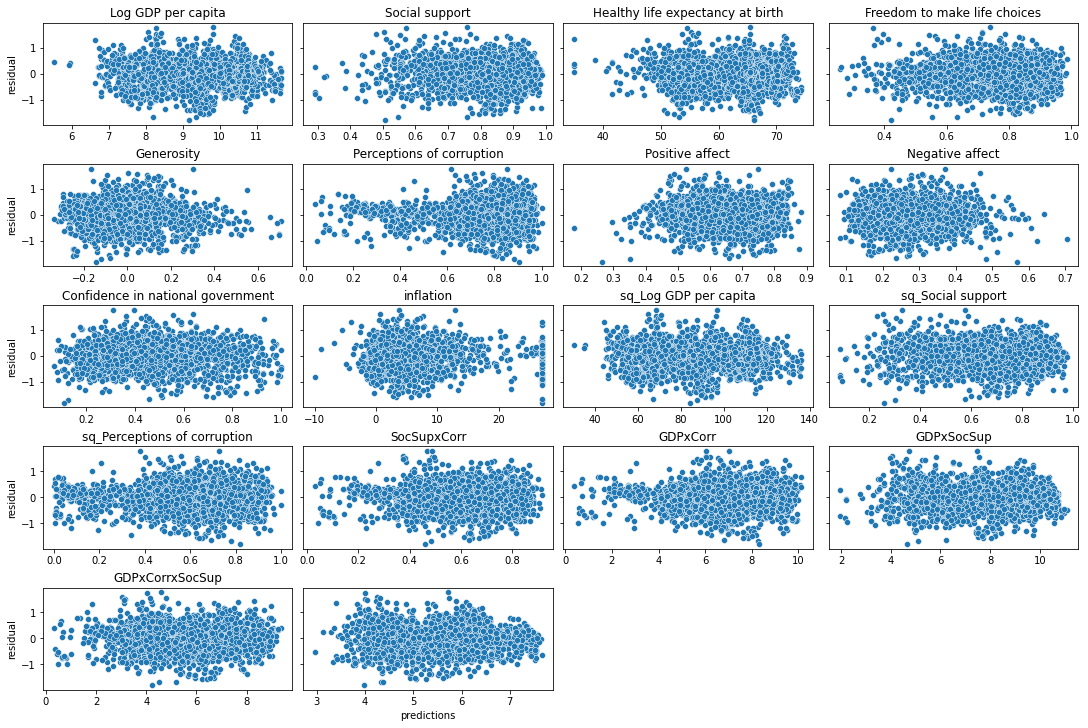

In [25]:
fig, axs = plt.subplots(5, 4, figsize=(15, 10), constrained_layout=True, sharex=False, sharey=True)
resids = result_expanded.resids.reset_index()["residual"]
x = sm.add_constant(wh_expanded.set_index(["Country name", "year"]).drop(columns=["Life Ladder"]))
preds = result_expanded.predict(x).reset_index()
for ax, col in zip(axs.flat, wh_expanded.drop(columns=["Country name", "year","Life Ladder"]).columns):
    sctrplt = sns.scatterplot(
        x=wh_expanded[col],
        y=resids,
        ax=ax
    )
    ax.set_title(col)
    ax.set_xlabel("")

sctrplt = sns.scatterplot(
    x=preds["predictions"],
    y=resids,
    ax=axs[4,1]
)
ax.set_title(col)
ax.set_xlabel("")

fig.delaxes(axs[4,2])
fig.delaxes(axs[4,3])

# The Next Step
In the next step, a proper division of data will be done to be able to use more advanced models. In the end, let us how much we can get from the data while explaining the happiness!